In [1]:
import torch
from decoder import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle

In [3]:
# data preperation
batch_size = 125
train_test_ratio = 0.85

with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_fixed_mono8_10k.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

print(pose.shape, img.shape)

ratio_id = int(data[0].shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

(10000, 2) (10000, 256, 256)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 2000

net = Conv_decoder()

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

epoch_losses = []
total_losses = []
test_losses = []

for epoch in range(epochs):
    net.train()
    batch_loss = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.unsqueeze(1).to(device)
        img = img.unsqueeze(1).to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        total_losses.append(loss)
        batch_loss.append(loss)

    scheduler.step()

    epoch_losses.append(np.mean(batch_loss))
    
    if epoch%10==0:
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.to(device)
            img = img.unsqueeze(1).to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_losses.append(loss)

        print('------ Epoch ', epoch)
        print('Epoch loss:', epoch_losses[-1])
        print('Val loss:', test_losses[-1])
        torch.save(net.state_dict(), "SPN3.pt")

Device:  cuda
------ Epoch  0
Epoch loss: 0.08910553562728797
Val loss: 0.10135654360055923
------ Epoch  10
Epoch loss: 0.08616573977119782
Val loss: 0.08156239241361618
------ Epoch  20
Epoch loss: 0.08610948021797572
Val loss: 0.08471309393644333
------ Epoch  30
Epoch loss: 0.08608952581005938
Val loss: 0.08420645445585251
------ Epoch  40
Epoch loss: 0.08605130904299371
Val loss: 0.0878199115395546
------ Epoch  50
Epoch loss: 0.08601928140748949
Val loss: 0.09307945519685745
------ Epoch  60
Epoch loss: 0.08594777347410426
Val loss: 0.08681797236204147
------ Epoch  70
Epoch loss: 0.08589049121912788
Val loss: 0.08836843818426132
------ Epoch  80
Epoch loss: 0.08580231304992647
Val loss: 0.08781828731298447
------ Epoch  90
Epoch loss: 0.0856955867698964
Val loss: 0.09822792559862137
------ Epoch  100
Epoch loss: 0.08553640380063478
Val loss: 0.08391301333904266
------ Epoch  110
Epoch loss: 0.08532963222002282
Val loss: 0.08283207565546036
------ Epoch  120
Epoch loss: 0.0851479

In [5]:
out = (epoch_losses, test_losses)

with open("losses_123.pkl", 'wb') as f:
    pickle.dump(out, f)

[ 2.385 -1.896]


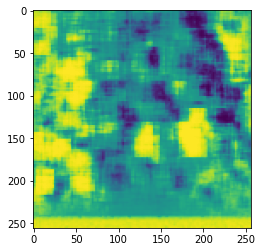

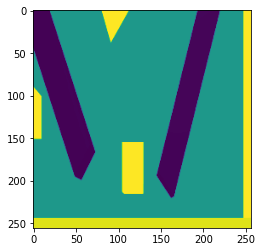

[ 1.507 -1.365]


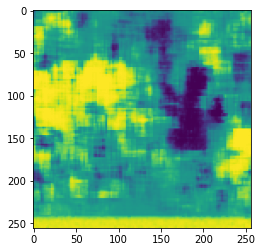

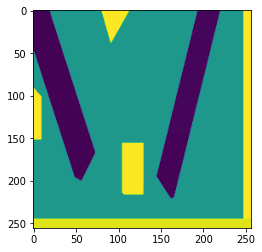

[ 7.791 -4.408]


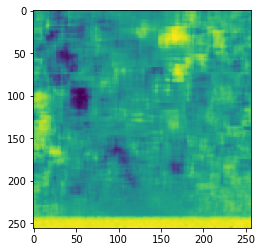

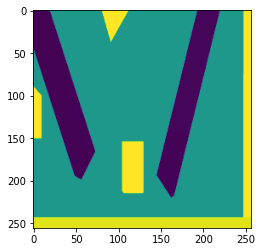

[ 1.617 -3.48 ]


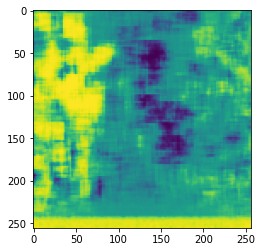

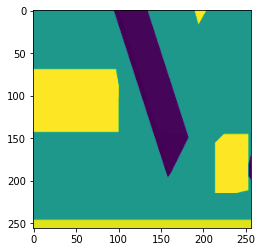

[3.858 3.774]


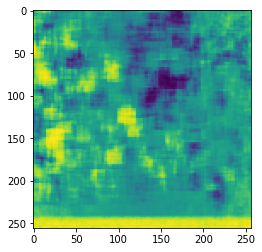

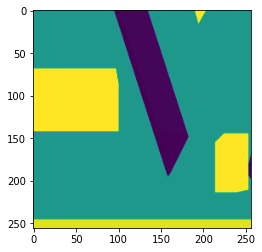

[ 4.198 -2.365]


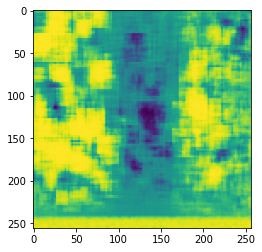

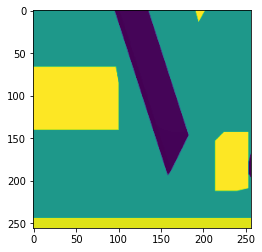

[-7.104 -4.707]


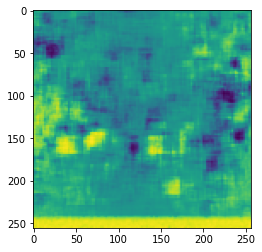

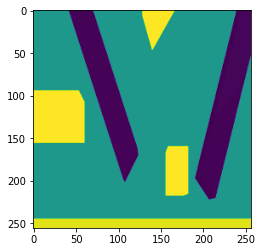

[-8.432  0.919]


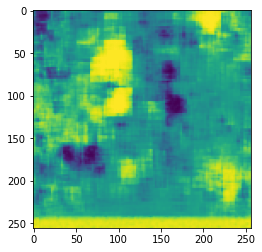

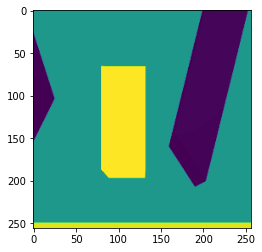

[-4.033  1.82 ]


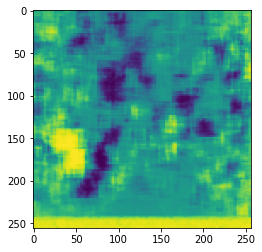

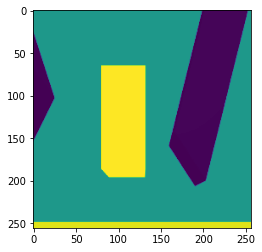

[-7.662 -7.694]


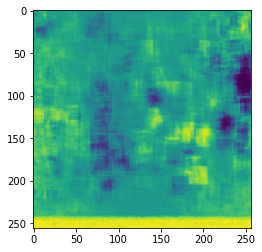

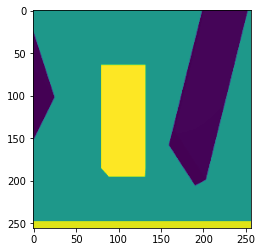

In [13]:
for i in range(0, 10):
    print(test_pose[i])
    plt.imshow(net(torch.tensor(test_pose[i]).cuda().float()).cpu().detach().numpy().squeeze())
    plt.show()
    plt.imshow(test_img[i])
    plt.show()

In [14]:
mean_test = [np.mean(test_losses[x:x+50]) for x in range(0, len(test_losses), 100)]

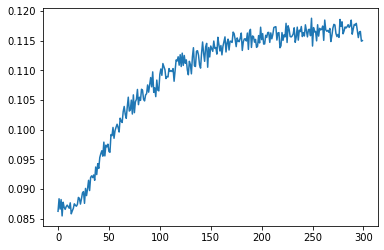

In [15]:
plt.plot(range(len(mean_test)), mean_test)

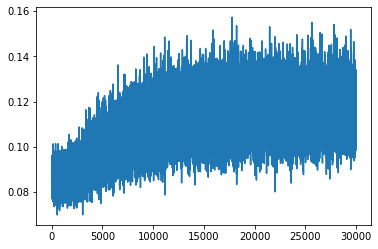

In [7]:
plt.plot(range(len(test_losses)), test_losses)

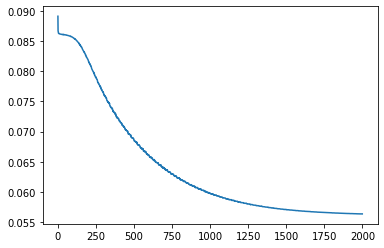

In [8]:
plt.plot(range(len(epoch_losses)), epoch_losses)